In [ ]:
import numpy as np
import skimage as sk
import skimage.io as skio
from skimage.util import crop
from skimage.transform import rescale
from matplotlib import pyplot as plt
from scipy.ndimage import shift, sobel
import glob
import os
import cv2
import skimage.io as io
from PIL import Image


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***`Colorizing the Prokudin-Gorskii Photo Collection`***
The goal of this assignment is to automatically produce color images from the digitized Prokudin-Gorskii glass plate
images by applying some simple image processing techniques. For that, you will need to extract the red/green/blue
color channels from the digitized plate images, and find the best alignment so that they form an RGB color image
with few visual artifacts. 


Function to show our images.

In [ ]:
def imshow(title="Image", image=None, size=8): #for showing images 
  w, h = image.shape[0], image.shape[1]
  aspect_ratio = w / h
  plt.figure(figsize=(size * aspect_ratio, size))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.title(title)
  plt.show()

Function to load our images.

In [ ]:
def loadRGB():
  images = []
  for img in glob.glob("drive/MyDrive/data/*.jpg"):
    im = skio.imread(img)
    images.append(im)
  return images

In [ ]:
images = loadRGB() # loading images

Let's look to the image.  

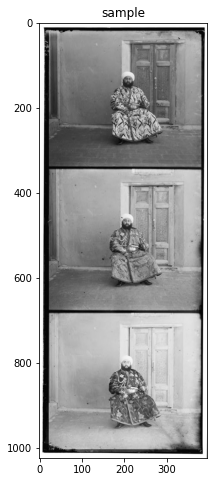

In [ ]:
sample = images[6]
imshow("sample", sample)

We have negatives that represent BGR, in order, with 3 pieces placed one under the other. 
First of all, we need to divide our photo into 3 parts. Then we'll trim the edges of each photo we've separated, and then we'll put them on the stack in BGR order. But before doing this, we will try to put the closest points on top of each other by shifting our BGR photos a little bit.

A Function to cropping border.

In [ ]:
def cropBorders(img = None):
  img1 = img[int(0.1 * len(img)):-int(0.1 * len(img)),
              int(0.1 * len(img[0])):-int(0.1 * len(img[0]))]
  return img1

Here, I use the Sum of squared differences method for pixel shifting, which has the best score in the similarity between our photos. Basically, our method navigates the range of -15 ,+15 for the x and y axes, and we accept the distance where the mean squared distance is the smallest as the optimal result with the distance calculation method. While doing this, we keep B stationary and move G and R.

In [ ]:
def SSD(img1_c, img2_c, placement=(-15, 15)):
    
    best_score = -float('inf') # best score  - infinite
    best_shift = [0, 0] #best shift default
    
    for i in range(placement[0], placement[1] + 1): # for x -15 to +15
        for j in range(placement[0], placement[1] + 1): # for y -15 to +15
            temp_score = score(np.roll(img1_c, (i, j), (0, 1)), img2_c) #calculate score with the score function after placement
            if temp_score > best_score: #if the new score bigger than the best score 
                best_score = temp_score # out new score becomes best score
                best_shift = [i, j]

    return np.roll(img1_c, best_shift, (0, 1)), np.array(best_shift) # with the best shift operation we are rolling our photos

def score(img1_c, img2_c): # calculating the score for SSD 

    img1_c = np.abs(sobel(img1_c))
    img2_c = np.abs(sobel(img2_c))
    return -np.sum(np.sum((img1_c - img2_c)**2)) 
    

Lets create our Gamma Correction Function.

In [ ]:
def gammaCorrection(src, gamma): #gamma correction function
    invGamma = 1 / gamma

    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)

    return cv2.LUT(src, table)

Function to colorize our images. First of all, it takes our photo and divides it into 3 equal parts, crops the edges of each of these divided photos, then calculates the optimal amount of scrolling of G and R to keep the top, B, constant and shifts the photos. Then BGR sequentially throws them on the stack.

In [ ]:
def colorize(img = None):
  height = int(len(sample)/3)
  B = img[:height]
  G = img[height:2*height]
  R = img[2*height:3*height]
  
  B = cropBorders(B)
  G = cropBorders(G)
  R = cropBorders(R)

  ag, g_shift = SSD(G, B)
  ar, r_shift = SSD(R, B)

  im_out = np.dstack([B,ag,ar])
  return im_out

Lets Colorize our images

In [ ]:
counter = 0
colorized_images = []
for im in images:
  imgC = colorize(im)
  colorized_images.append(imgC)

Lets look 8 samples.

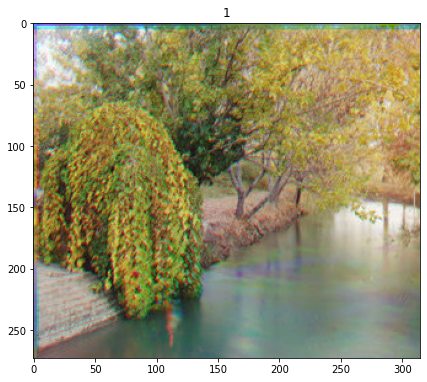

In [ ]:
sample1 =  colorized_images[1]
imshow("1", sample1)

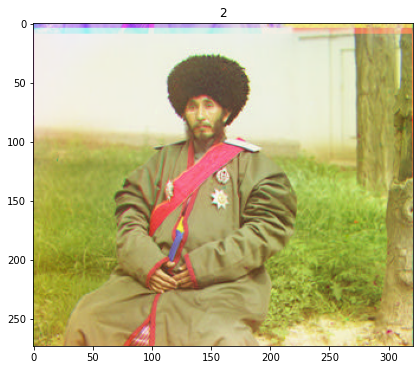

In [ ]:
sample2 =  colorized_images[2]
imshow("2", sample2)

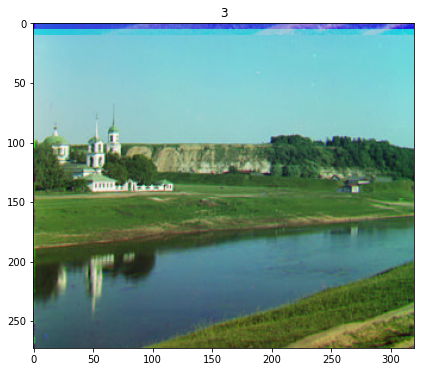

In [ ]:
sample3 =  colorized_images[3]
imshow("3", sample3)

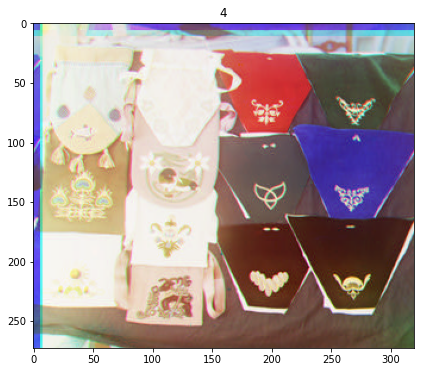

In [ ]:
sample4 =  colorized_images[4]
imshow("4", sample4)

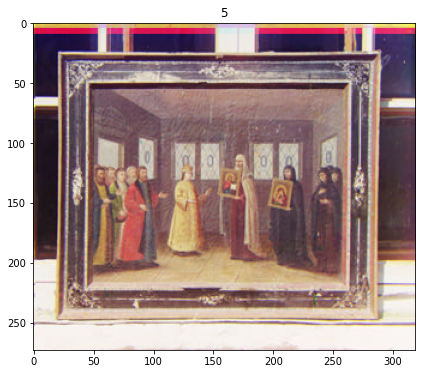

In [ ]:
sample5 =  colorized_images[5]
imshow("5", sample5)

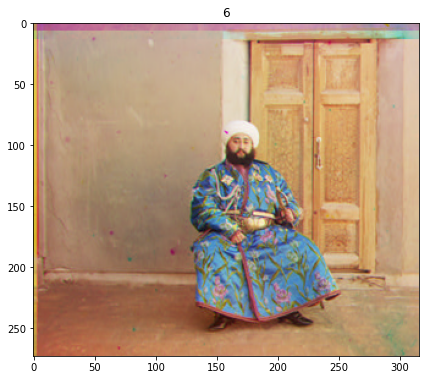

In [ ]:
sample6 =  colorized_images[6]
imshow("6", sample6)

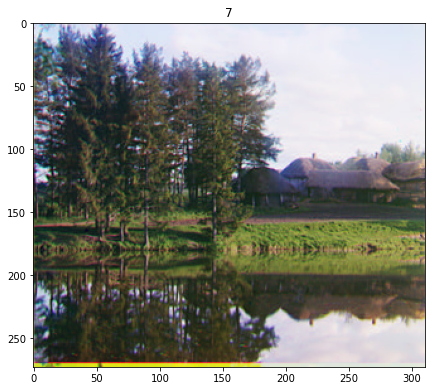

In [ ]:
sample7 =  colorized_images[7]
imshow("7", sample7)

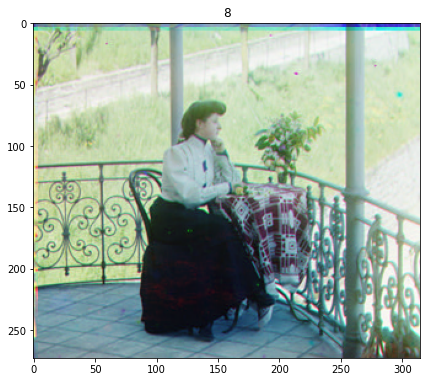

In [ ]:
sample8 =  colorized_images[8]
imshow("8", sample8)

Lets improve the quality of our images with Gamma Correction and Noise Removing

In [ ]:
improved_images = []
for im in colorized_images:
  img = gammaCorrection(im, 0.7)
  sampleI = cv2.fastNlMeansDenoisingColored(img,None,3,3,2,7)
  improved_images.append(sampleI)

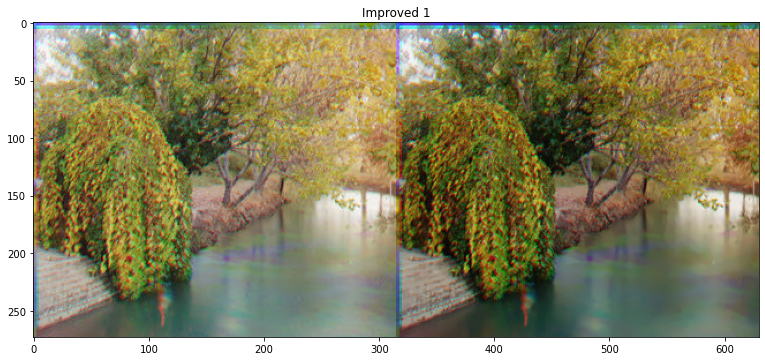

In [ ]:
sample1I = improved_images[1]
sample1I = cv2.hconcat([sample1, sample1I])
imshow("Improved 1", sample1I ,size = 30)

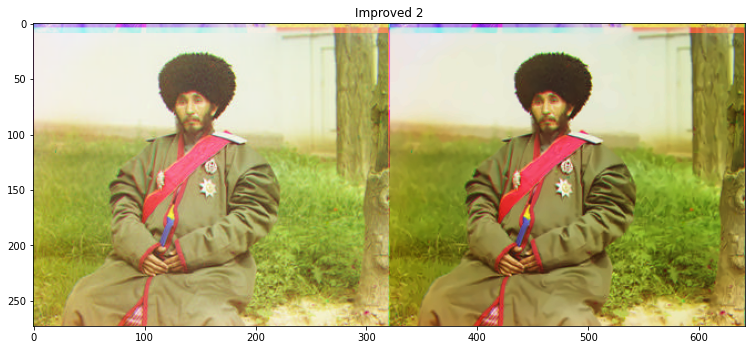

In [ ]:
sample2I = improved_images[2]
sample2I = cv2.hconcat([sample2, sample2I])
imshow("Improved 2", sample2I ,size = 30)

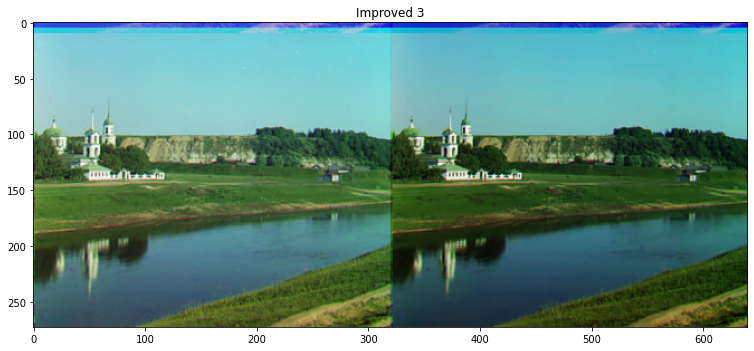

In [ ]:
sample3I = improved_images[3]
sample3I = cv2.hconcat([sample3, sample3I])
imshow("Improved 3", sample3I ,size = 30)

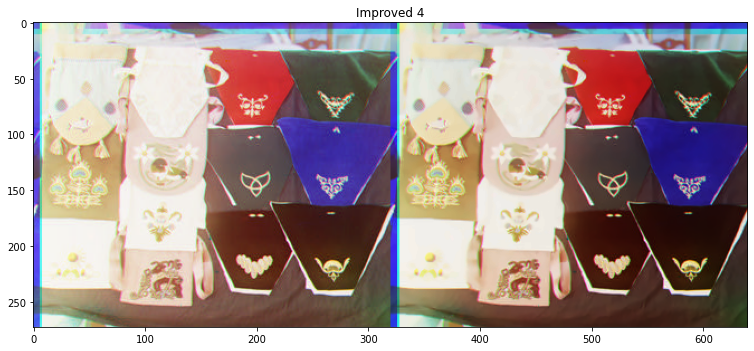

In [ ]:
sample4I = improved_images[4]
sample4I = cv2.hconcat([sample4, sample4I])
imshow("Improved 4", sample4I ,size = 30)

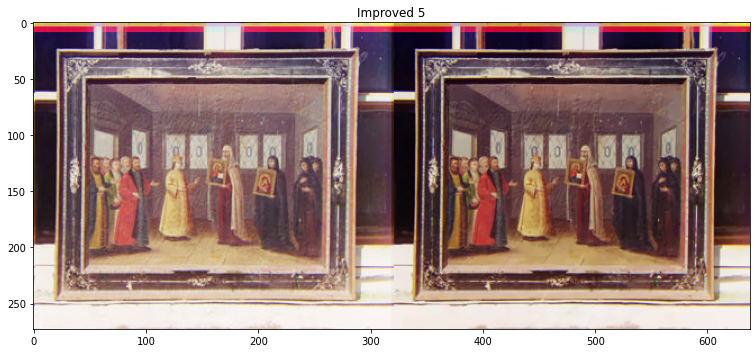

In [ ]:
sample5I = improved_images[5]
sample5I = cv2.hconcat([sample5, sample5I])
imshow("Improved 5", sample5I ,size = 30)

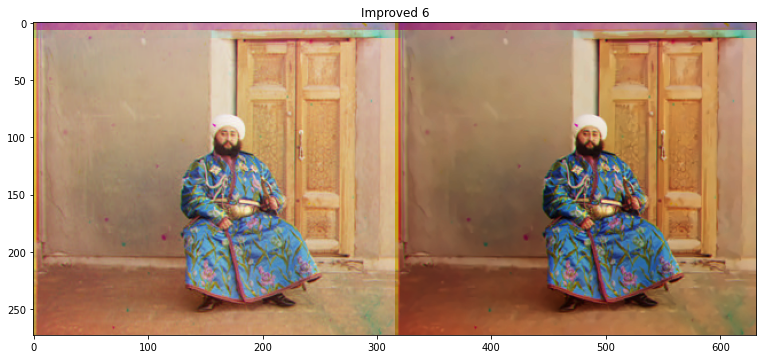

In [ ]:
sample6I = improved_images[6]
sample6I = cv2.hconcat([sample6, sample6I])
imshow("Improved 6", sample6I ,size = 30)

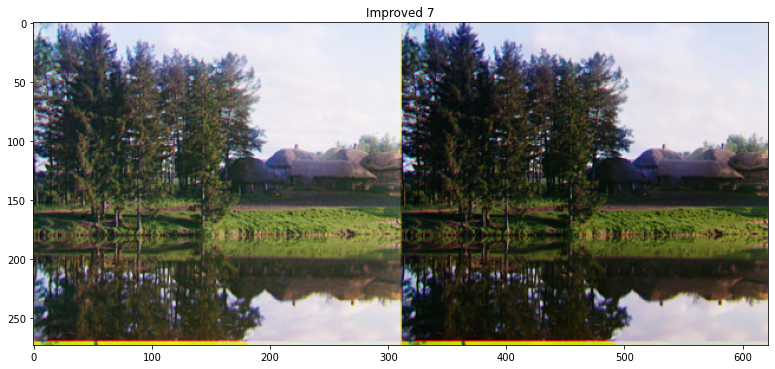

In [ ]:
sample7I = improved_images[7]
sample7I = cv2.hconcat([sample7, sample7I])
imshow("Improved 7", sample7I ,size = 30)

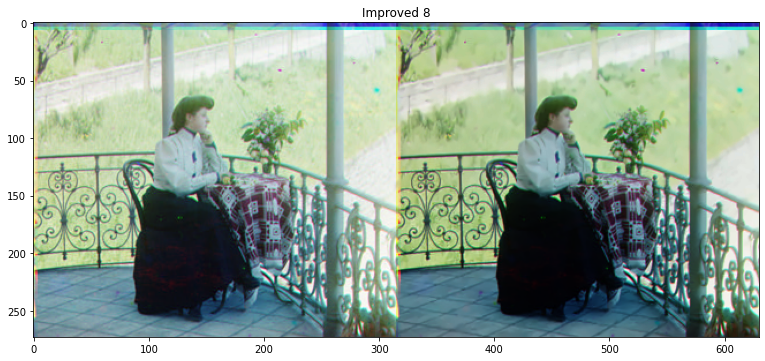

In [ ]:
sample8I = improved_images[8]
sample8I = cv2.hconcat([sample8, sample8I])
imshow("Improved 8", sample8I ,size = 30)

# ***`Conclusion`***

First, we divided our images into 3 parts. Then we combined our piece images. While combining, we tried to keep the similarity maximum with the sum of squared differences method. Finally, because our photos have poor quality and low resolution, we have increased the color quality of our Gamma Correction and Noise Removing photos, making them look more beautiful to the eye.

In [ ]:
%%shell
jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/AIN 432 ass1.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/AIN 432 ass1.ipynb to html
[NbConvertApp] Writing 7037571 bytes to /content/drive/MyDrive/Colab Notebooks/AIN 432 ass1.html
